<h1>Мат. Пакеты, лаб. работа №1, 9383, Гордон Дмитрий<h1>

<h2>1. Загрузка .wav файла<h2>

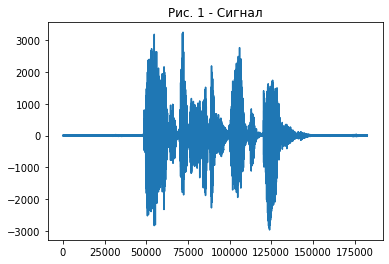

In [4]:
import math
from scipy import signal
from matplotlib import pyplot as plt
from scipy.io.wavfile import write
import numpy as np
import wave
import sys
spf = wave.open("lab1.wav", "r")

# Extract Raw Audio from Wav File
data = spf.readframes(-1)
data = np.frombuffer(data, "int16")
plt.figure(1)
plt.title("Рис. 1 - Сигнал")
plt.plot(data)
plt.show()

<h2>2. Огибающая (wave envelope)<h2>

$$x(i), i = 0, 1,..., N - 1 - сигнал$$
$$f(j), j = 0, 1,..., n - 1 - огибающая$$
$$m = \left[\frac{N}{n}\right] - точки$$
$$m = N / n = N / N / 1000 = 1000$$
$$y(j) = \frac{1}{m} \sum_{k=mj}^{mj+m-1} |x(k)|$$

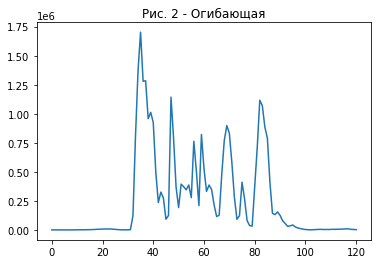

In [5]:
envelope = [];
m = 1500
for j in range(0, math.floor(data.size/m)):
    envelope.append(sum(abs(data[k]) for k in range(m*j, m*j + m - 1)))
plt.figure(1)
plt.title("Рис. 2 - Огибающая")
plt.plot(envelope)
plt.show()

<h2>3. Фильтрация<h2>

$$\text{Пусть}F_d\text{ - частота дискретизации (48000), частота среза - }F_s\text{(900)}\text{, порядок фильтра - }m$$
$$\text{Тогда вычисляем:}$$
$$wn = 2 \frac{F_s}{F_d}$$
$$\text{Был выбран фильтр нижних частот}$$

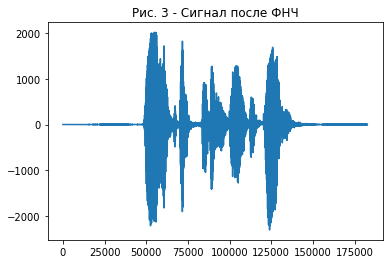

In [6]:
Fs = 900
Fd = 48000
wn = 2 * Fs / Fd
b, a = signal.butter(4, wn, 'lowpass')
filtedData = signal.filtfilt(b, a, data)
plt.figure(1)
plt.title("Рис. 3 - Сигнал после ФНЧ")
plt.plot(filtedData)
plt.show()
write('lab1_filted.wav', 48000, filtedData.astype(np.int16))

<h2>4. Детектор сигнал/шум<h2>

$$\text{Определяем среднее сигнала по амплитуде (без учета знака):}$$
$$mid = \frac{1}{N} \sum_{k=0}^{N-1} |x(k)|$$
$$\text{Определяем порог детектора}- Th = \alpha * mid,\text{ где } 0 < \alpha < 1 \text{ подбирается экспериментально (я выбрал 0.5).}$$
$$\text{Задаём велечину "провала"(в отчетах)}- k \text{ (я выбрал 5; если больше, то ничего не слышно)}$$
$$\text{Обозначим }y(i) - \text{сигнал после детектирования}$$
$$\text{Событие "начало сигнала". Если }x(i)\text{ в течение }k\text{ отчётов превышает порог, }y(i) = x(i)$$
$$\text{Событие "окончание сигнала". Если }x(i)\text{ в течение }k\text{ отчётов меньше порога, }y(i) = 0$$

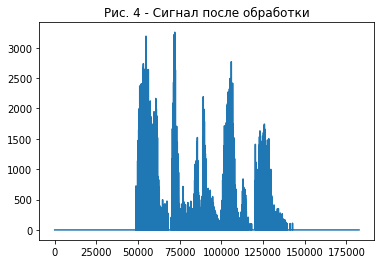

In [7]:
mid = sum(abs(data[k]) for k in range(0, data.size - 1)) / data.size
a = 0.5
th = a * mid
k = 5
noiseData = []
duration = 0
for value in data:
    if(value > th):
        duration += 1
    else:
        duration = 0
    if(duration >= k):
        noiseData.append(value)
    else:
        noiseData.append(0)
plt.figure(1)
plt.title("Рис. 4 - Сигнал после обработки")
plt.plot(noiseData)
plt.show()
noiseData = np.array(noiseData)
write('lab1_noise.wav', 48000, noiseData.astype(np.int16))

<h2>5. Эффект Эхо<h2>

$$\text{Ревербератор реализован, как набор линий задержки. Число линий задержки} - N_L \geq 8$$
$$\text{Каждая линия задержки имеет свой весовой коэффициент (задаётся пользователем):}$$
$$\alpha_1 > \alpha_2 > ... > \alpha_{N_L}$$
$$\text{Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.}$$
$$\text{Желаемое соотношение между "сухим" и обработанным сигналом задаётс коэффициентом применимости}- \gamma$$
$$\text{Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset). Для ручного режима регулируется пользователем задаётся максимальная задержка - }D_i \text{, а величины остальных определяются автоматически через неё:}$$
$$D_i = D_1 2^{\frac{1-i}{N_L}}, i = 2,..., N_L$$
$$\text{Для готовой конфигурации пользователь вручную задаёт последовательность (я выбрал первый вариант - задал }D_1:$$
$$D_1 = \frac{75 * 48000}{335}=10746$$

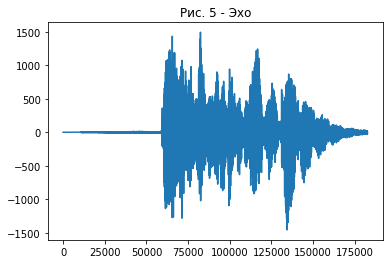

In [8]:
echoData = np.zeros(len(data))    #result
reverb_c = np.array([0.9]) #alpha coefficients
N_L = 8
for i in range(0, N_L - 1):
    reverb_c = np.append(reverb_c, reverb_c[-1] * 0.5)
gamma = 0.5
D_1 = 75 * 48000/335
D_i = np.array([D_1], dtype = 'int16')
for i in range(2, N_L + 1):
    D_i = np.append(D_i, int(D_i[0] * 2 ** ((1 - i)/N_L)))
subEchoData = np.array([])
delay = 0
for i, value in enumerate(D_i):
    delay += value
    subEchoData = np.roll(data, delay) * reverb_c[i]
    subEchoData[:delay] = 0
    echoData += subEchoData

#filter
Fs = 1000
Fd = 48000
wn = 2 * Fs / Fd
b, a = signal.butter(4, wn, 'lowpass')
filtedData = signal.filtfilt(b, a, echoData)

#multiply by gamma
echoData *= gamma

#graphics
plt.figure(1)
plt.title("Рис. 5 - Эхо")
plt.plot(echoData)
plt.show()
write('lab1_echo.wav', 48000, echoData.astype(np.int16))

<h2>6. Distortion<h2>

$$\text{Обозначим входной сигнал и выходной сигналы, соответственно как }x(i), y(i) i = 0, 1,..., N - 1.$$
$$\text{Пользователь задаёт порог - }Th\text{ и максимальное значение сигнала }Max > Th\text{. Тогда:}$$
\begin{equation*}
Y(i) = 
 \begin{cases}
   x(i), &|x(i)| \leq Th\\
   Max * sign(x(i)), &\text{иначе}
 \end{cases}
\end{equation*}

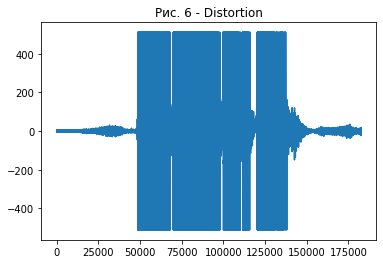

In [9]:
def sign(number):
    if(number < 0):
        return -1
    return 1
Max = 3 * mid
distortionData = []
for value in data:
    if(abs(value) <= mid):
        distortionData.append(value)
    else:
        distortionData.append(Max * sign(value))
plt.figure(1)
plt.title("Рис. 6 - Distortion")
plt.plot(distortionData)
plt.show()
distortionData = np.array(distortionData)
write('lab1_distortion.wav', 48000, distortionData.astype(np.int16))

<h2>Выводы<h2>
    В ходе лабораторной работы был загружен .wav файл и проведены следующие манипуляции с ним:
    1. Построение огибающей,
    2. Обработка ФНЧ,
    3. Создание эффекта эхо,
    4. Детектор сигнал/шум,
    5. Создание эффекта "Distorion"